Upload Kaggle API token file.

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"featgautham","key":"44e6480788b83feca8e05bbbfee4e611"}'}

Setting up Kaggle in Colab and downloading data files from Kaggle.

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nih-chest-xrays/sample

 99% 2.08G/2.10G [00:24<00:00, 111MB/s]
100% 2.10G/2.10G [00:24<00:00, 91.8MB/s]


Unzipping the files to extract the data.

In [0]:
!unzip sample.zip

Archive:  sample.zip
  inflating: images/00000013_005.png  
  inflating: images/00000013_026.png  
  inflating: images/00000017_001.png  
  inflating: images/00000030_001.png  
  inflating: images/00000032_001.png  
  inflating: images/00000040_003.png  
  inflating: images/00000042_002.png  
  inflating: images/00000057_001.png  
  inflating: images/00000061_002.png  
  inflating: images/00000061_019.png  
  inflating: images/00000061_025.png  
  inflating: images/00000079_000.png  
  inflating: images/00000080_005.png  
  inflating: images/00000083_000.png  
  inflating: images/00000084_000.png  
  inflating: images/00000096_006.png  
  inflating: images/00000099_003.png  
  inflating: images/00000099_006.png  
  inflating: images/00000103_001.png  
  inflating: images/00000116_013.png  
  inflating: images/00000116_019.png  
  inflating: images/00000116_032.png  
  inflating: images/00000116_040.png  
  inflating: images/00000118_011.png  
  inflating: images/00000121_004.png  
  in

Install dependancies.

In [0]:
import os
import random
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import keras

from glob import glob
from itertools import chain

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Using TensorFlow backend.


Read data as dataframe.

In [0]:
data1 = pd.read_csv('sample_labels.csv')
data1.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3814,00018735_010.png,No Finding,10,18735,017Y,F,PA,2786,2991,0.143000,0.143000
5576,00030439_006.png,No Finding,6,30439,056Y,F,PA,2021,2021,0.194311,0.194311
929,00004858_082.png,Mass,82,4858,043Y,F,PA,2542,2487,0.143000,0.143000


Get file path for each image.

In [0]:
image_dir = glob('/content/images/**')
image_paths = {os.path.basename(x): x for x in image_dir}
data1['Path'] = data1['Image Index'].map(image_paths.get)
data1 = data1.drop(['Follow-up #','Patient ID','Patient Gender','View Position','OriginalImageWidth','OriginalImageHeight','OriginalImagePixelSpacing_x','OriginalImagePixelSpacing_y'], axis =1)
data1.sample(3)

,Image Index,Finding Labels,Patient Age,Path
5265,00028290_003.png,No Finding,070Y,/content/images/00028290_003.png
395,00002048_013.png,Consolidation,043Y,/content/images/00002048_013.png
5474,00029809_005.png,No Finding,063Y,/content/images/00029809_005.png


Plot random images.

In [0]:
def plot_random_images():
    r = random.sample(image_dir, 9)
    plt.figure(figsize=(13,10))
    plt.subplot(141)
    plt.imshow(cv2.imread(r[0])); plt.axis('off')
    plt.subplot(142)
    plt.imshow(cv2.imread(r[1])); plt.axis('off')
    plt.subplot(143)
    plt.imshow(cv2.imread(r[2])); plt.axis('off')
    plt.subplot(144)
    plt.imshow(cv2.imread(r[3])); plt.axis('off')

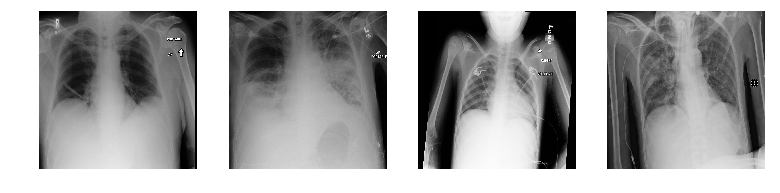

In [0]:
plot_random_images()

Finding labels in the dataset.

In [0]:
all_labels = np.unique(data1['Finding Labels'])
all_labels

array(['Atelectasis', 'Atelectasis|Cardiomegaly',
       'Atelectasis|Cardiomegaly|Consolidation',
       'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Mass|Pleural_Thickening',
       'Atelectasis|Cardiomegaly|Effusion',
       'Atelectasis|Cardiomegaly|Effusion|Fibrosis|Infiltration',
       'Atelectasis|Cardiomegaly|Effusion|Fibrosis|Nodule',
       'Atelectasis|Cardiomegaly|Effusion|Infiltration|Pleural_Thickening',
       'Atelectasis|Cardiomegaly|Effusion|Mass',
       'Atelectasis|Cardiomegaly|Infiltration',
       'Atelectasis|Consolidation', 'Atelectasis|Consolidation|Edema',
       'Atelectasis|Consolidation|Edema|Effusion|Infiltration',
       'Atelectasis|Consolidation|Edema|Infiltration|Pneumonia',
       'Atelectasis|Consolidation|Effusion',
       'Atelectasis|Consolidation|Effusion|Emphysema',
       'Atelectasis|Consolidation|Effusion|Emphysema|Nodule|Pneumothorax',
       'Atelectasis|Consolidation|Effusion|Fibrosis|Pleural_Thickening',
       'Atelect

Check the count of unique labels.

In [0]:
len(all_labels)

244

There seems to both single class and multiple class images. Get a unique list of all the single classes in the dataset.

In [0]:
all_labels = np.unique(list(chain(*data1['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

Shuffle the data and check the total number of images.

In [0]:
np.random.shuffle(data1.values)
data1.shape

(5606, 4)

Create a function to resize images and store in image and label arrays. A single class per image approach to be undertaken and 'No Finding' labels to be removed.

In [0]:
def image_label_arrays():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    Atelectasis = 'Atelectasis'
    Cardiomegaly = 'Cardiomegaly'
    Consolidation = 'Consolidation'
    Edema = 'Edema'
    Effusion = 'Effusion'
    Emphysema = 'Emphysema'
    Fibrosis = 'Fibrosis'
    Hernia = 'Hernia'
    Infiltration = 'Infiltration'
    Mass = 'Mass'
    Nodule = 'Nodule'
    Pleural_Thickening = 'Pleural_Thickening'
    Pneumonia = 'Pneumonia'
    Pneumothorax = 'Pneumothorax'
       
    image_dir = glob('/content/images/**')
    x = [] # images as arrays
    y = [] # labels
    WIDTH = 46
    HEIGHT = 46
    
    for img in image_dir:
        image_paths2 = os.path.basename(img)
        # Read and resize image
        full_size_image = cv2.imread(img)
        diagnosis = data1["Finding Labels"][data1["Image Index"] == image_paths2].values[0]
        symbol = "|"
        if symbol in diagnosis:
            continue
        else:
            if Atelectasis in diagnosis:
                diagnosis = 1
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Cardiomegaly in diagnosis:
                diagnosis = 2
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Consolidation in diagnosis:
                diagnosis = 3
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Edema in diagnosis:
                diagnosis = 4
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Effusion in diagnosis:
                diagnosis = 5
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Emphysema in diagnosis:
                diagnosis = 6
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Fibrosis in diagnosis:
                diagnosis = 7
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Hernia in diagnosis:
                diagnosis = 8
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Infiltration in diagnosis:
                diagnosis = 9
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Mass in diagnosis:
                diagnosis = 10
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Nodule in diagnosis:
                diagnosis = 11
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pleural_Thickening in diagnosis:
                diagnosis = 12
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumonia in diagnosis:
                diagnosis = 13
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumothorax in diagnosis:
                diagnosis = 14
                y.append(diagnosis)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            else:
                continue
    return x,y

Check the total number of single class images without 'No Finding' label.

In [0]:
x,y = image_label_arrays()
data2 = pd.DataFrame()
data2["Images"]=x
data2["Labels"]=y
print(len(data2), data2.Images[0].shape)

1582 (256, 256, 3)


* Normalize the images.

* Convert the labels to float values.

In [0]:
x = np.array(x).astype('float32')/255.0

y = np.array(y).astype('float32')

Split the data into training and test datasets (80% : 20%)

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

print(len(x_train), len(y_train), len(x_test), len(y_test))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

1265 1265 317 317
(1265, 256, 256, 3) (1265,) (317, 256, 256, 3) (317,)


Reshape the datasets to 2 dimensions.

In [0]:
x_train = x_train.reshape(1265,-2)
x_test = x_test.reshape(317,-2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1265, 196608) (1265,) (317, 196608) (317,)


In [0]:
from sklearn import svm, metrics

classifier = svm.SVC().fit(x_train,y_train)
y_pred = classifier.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred)*100,"%")